In [1]:
import pyodbc
import sqlalchemy
import dotenv
import os

In [2]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import cross_val_predict, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import SGDRegressor, LinearRegression, RidgeCV, RANSACRegressor, ElasticNetCV, PassiveAggressiveRegressor, PoissonRegressor, GammaRegressor, TweedieRegressor, BayesianRidge, LarsCV
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor, StackingRegressor, ExtraTreesRegressor

from sklearn.base import BaseEstimator, RegressorMixin
import tensorflow as tf
import keras
from scikeras.wrappers import KerasRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import BaseCrossValidator
from matplotlib.pyplot import axline

In [4]:
dotenv.load_dotenv()

sql_server = os.getenv('SQL_SERVER')
db_conn_string = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={sql_server};DATABASE=japan;Trusted_Connection=yes;'
connection_url = sqlalchemy.engine.URL.create(
    "mssql+pyodbc", 
    query={"odbc_connect": db_conn_string}
)
engine = sqlalchemy.create_engine(connection_url)
df_japan = pd.read_sql('SELECT * FROM Transactions', engine)

print(df_japan.head())

       ID  RealEstateType  Region  Prefecture  City  District  NearestStation  \
0  435310              56    46.0          20   373   38907.0          2807.0   
1  435311              56    46.0          20   373   38907.0          2807.0   
2  435312              56    46.0          20   373   38907.0          2807.0   
3  435313              56    46.0          20   373   38173.0          2810.0   
4  435314              56    46.0          20   373   38173.0          2793.0   

   MinTimeToNearestStation  MaxTimeToNearestStation       Price  ...  \
0                     21.0                     21.0   4000000.0  ...   
1                     26.0                     26.0  21000000.0  ...   
2                     26.0                     26.0  10000000.0  ...   
3                     13.0                     13.0  12000000.0  ...   
4                      9.0                      9.0  37000000.0  ...   

   LandShape  BuildingYear  PrewarBuilding  Structure  CurrentUsage  \
0      11

In [5]:
print(df_japan.describe())

                  ID  RealEstateType        Region    Prefecture  \
count   56877.000000    56877.000000  42273.000000  56877.000000   
mean   463748.000000       57.941048     46.290635     20.370308   
std     16419.119967        1.389881      0.706224      0.482891   
min    435310.000000       56.000000     45.000000     20.000000   
25%    449529.000000       56.000000     46.000000     20.000000   
50%    463748.000000       59.000000     46.000000     20.000000   
75%    477967.000000       59.000000     46.000000     21.000000   
max    492186.000000       60.000000     48.000000     21.000000   

               City      District  NearestStation  MinTimeToNearestStation  \
count  56877.000000  56824.000000    43594.000000             43538.000000   
mean     382.745451  38511.082060     2874.801601                24.579678   
std       10.419137    911.745222       65.796593                19.014307   
min      372.000000  36998.000000     2766.000000                 0.000000 

In [6]:
print(df_japan.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56877 entries, 0 to 56876
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            56877 non-null  int64  
 1   RealEstateType                56877 non-null  int64  
 2   Region                        42273 non-null  float64
 3   Prefecture                    56877 non-null  int64  
 4   City                          56877 non-null  int64  
 5   District                      56824 non-null  float64
 6   NearestStation                43594 non-null  float64
 7   MinTimeToNearestStation       43538 non-null  float64
 8   MaxTimeToNearestStation       43070 non-null  float64
 9   Price                         56877 non-null  float64
 10  UnitPrice                     27774 non-null  float64
 11  FloorPlan                     1356 non-null   float64
 12  Area                          56877 non-null  float64
 13  G

In [7]:
columns_to_encode = ['RealEstateType', 'Region', 'Prefecture', 'City', 'District', 'FrontageRoadType', 'FrontageRoadDirection', 'LandShape', 'PlanningType']
# Floorplan, CurrentUsage, PostTransactionUsage, Structure, BuildingYear either drop or input with unknown
columns_to_drop = ['ID', 'NearestStation', 'TransactionQuarter', 'Price', 'UnitPrice', 'FloorArea']
tentative_columns = ['FloorPlan', 'CurrentUsage', 'PostTransactionUsage', 'Structure', 'BuildingYear']
numerical_values = ['MinTimeToNearestStation', 'MaxTimeToNearestStation', 'Area', 'GreatArea', 'GreatFloorArea', 'FrontageRoadBreadth', 'PrewarBuilding', 'MaximumBuildingCoverageRatio', 'TransactionYear']

price = df_japan['Price']

df_japan = df_japan.drop(columns=columns_to_drop)
df_japan = df_japan.drop(columns=tentative_columns)
print(df_japan.info())
print(df_japan.drop(columns=columns_to_encode).info())

df_japan = pd.get_dummies(df_japan, columns=columns_to_encode)
print(df_japan.info())
print(df_japan.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56877 entries, 0 to 56876
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   RealEstateType                56877 non-null  int64  
 1   Region                        42273 non-null  float64
 2   Prefecture                    56877 non-null  int64  
 3   City                          56877 non-null  int64  
 4   District                      56824 non-null  float64
 5   MinTimeToNearestStation       43538 non-null  float64
 6   MaxTimeToNearestStation       43070 non-null  float64
 7   Area                          56877 non-null  float64
 8   GreatArea                     56877 non-null  bool   
 9   GreatFloorArea                56877 non-null  bool   
 10  FrontageRoadType              40224 non-null  float64
 11  FrontageRoadDirection         41810 non-null  float64
 12  FrontageRoadBreadth           39799 non-null  float64
 13  L

In [8]:
print(df_japan.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56877 entries, 0 to 56876
Columns: 3239 entries, MinTimeToNearestStation to PlanningType_224.0
dtypes: bool(3233), float64(5), int64(1)
memory usage: 178.0 MB
None


# Models

In [9]:
def build_dnn(meta): 
    model= keras.models.Sequential([
                    keras.layers.Dense(200,activation='leaky_relu', input_dim=meta["n_features_in_"]),
                    keras.layers.LayerNormalization(),
                    keras.layers.Dense(400,activation='leaky_relu'),
                    keras.layers.Dropout(0.2),
                    keras.layers.Dense(600,activation='leaky_relu'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(400,activation='leaky_relu'),
                    keras.layers.Dropout(0.2),
                    keras.layers.Dense(200,activation='leaky_relu'),
                    keras.layers.Dense(100,activation='leaky_relu'),
                    keras.layers.Dropout(0.2),
                    keras.layers.Dense(50,activation='leaky_relu'),
                    keras.layers.Dense(1, activation='linear')
        ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
            loss='mean_squared_error',
            metrics=['RootMeanSquaredError'])
    return model

# hist = dnn_pipeline.fit(X_train, y_train)   
# print("score: ", hist.score(X_test, y_test))
# predicted = dnn_pipeline.predict(X_test)
# actual = y_test

In [17]:
def create_models():
    #sgd_reg = SGDRegressor() // ('sgd_reg', sgd_reg) # też sprawdzić...
    #lin_reg = LinearRegression(), ('lin_reg', lin_reg)
    ridge_reg = RidgeCV()
    gb_reg = GradientBoostingRegressor()
    #ransac_reg = RANSACRegressor() #loss='squared_error', ('ransac_reg', ransac_reg)
    #elastic_reg = ElasticNetCV() # l1_ratio=[.5, .75, .9, .99], cv=5, positive=True ('elastic_reg', elastic_reg)
    # theilsen_reg = TheilSenRegressor() //, ('theilsen_reg', theilsen_reg)
    bayes_reg = BayesianRidge()
    #pasagr_reg = PassiveAggressiveRegressor() # C=.5, sprawdzić więcej... , ('pasagr_reg', pasagr_reg)
    gamma_reg = GammaRegressor()
    poisson_reg = PoissonRegressor(max_iter=3000)
    tweedie1_reg = TweedieRegressor(power=1, max_iter=3000)
    tweedie2_reg = TweedieRegressor(power=2, max_iter=1500)
    dnn_reg = KerasRegressor(build_dnn, epochs=50, verbose=False)
    estimators = [ ('gb_reg', gb_reg), ('dnn_reg', dnn_reg), #('ridge_reg', ridge_reg),("bayes_reg", bayes_reg),
                  ('gamma_reg', gamma_reg), ('poisson_reg', poisson_reg), ('tweedie1_reg', tweedie1_reg), ('tweedie2_reg', tweedie2_reg)]
    voting_reg = VotingRegressor(estimators=estimators)
    stacking_reg = StackingRegressor(estimators=estimators, final_estimator=ExtraTreesRegressor(), cv=5, n_jobs=-1)
    stacking_reg2 = StackingRegressor(estimators=estimators, final_estimator=RidgeCV(), cv=5, n_jobs=-1)
    return [
        # Pipeline([
        #     ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        #     ('scaler', StandardScaler()),
        #     ('model', sgd_reg)
        # ]),
        # Pipeline([
        #     ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        #     ('scaler', StandardScaler()),
        #     ('model', ransac_reg)
        # ]),
        # Pipeline([
        #     ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        #     ('scaler', StandardScaler()),
        #     ('model', elastic_reg)
        # ]),
        # Pipeline([
        #     ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        #     ('scaler', StandardScaler()),
        #     ('model', theilsen_reg)
        # ]),
        # Pipeline([
        #     ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        #     ('scaler', StandardScaler()),
        #     ('model', pasagr_reg)
        # ]),
        Pipeline([
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
            ('scaler', StandardScaler()),
            ('model', ridge_reg)
        ]),
        Pipeline([
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
            ('scaler', StandardScaler()),
            ('model', gb_reg)
        ]),
        Pipeline([
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
            ('scaler', StandardScaler()),
            ('model', bayes_reg)
        ]),
        Pipeline([
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
            ('scaler', StandardScaler()),
            ('model', poisson_reg)
        ]),
        Pipeline([
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
            ('scaler', StandardScaler()),
            ('model', gamma_reg)
        ]),
        Pipeline([
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
            ('scaler', StandardScaler()),
            ('model', tweedie1_reg)
        ]),
        Pipeline([
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
            ('scaler', StandardScaler()),
            ('model', tweedie2_reg)
        ]),
        Pipeline([
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
            ('scaler', StandardScaler()),
            ('model', dnn_reg)
        ]),
        Pipeline([
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
            ('scaler', StandardScaler()),
            ('model', voting_reg)
        ]),
        Pipeline([
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
            ('scaler', StandardScaler()),
            ('model', stacking_reg)
        ]),
        Pipeline([
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
            ('scaler', StandardScaler()),
            ('model', stacking_reg2)
        ])
    ]

# Training

### Split data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_japan, price, test_size=0.2)

### Fit models

RidgeCV()
score:  0.3228562438354825


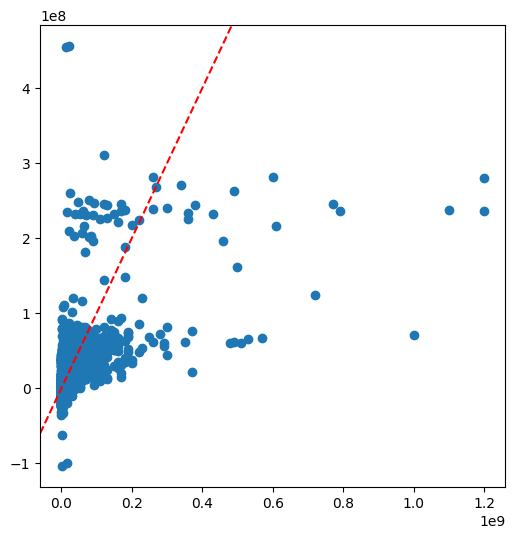

GradientBoostingRegressor()
score:  0.43158637023728774


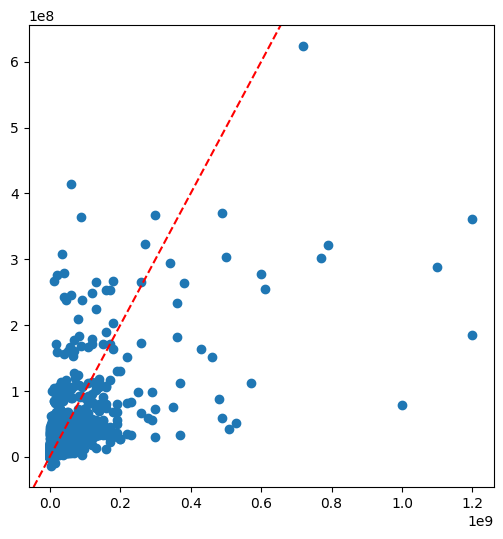

BayesianRidge()
score:  0.3206391848051382


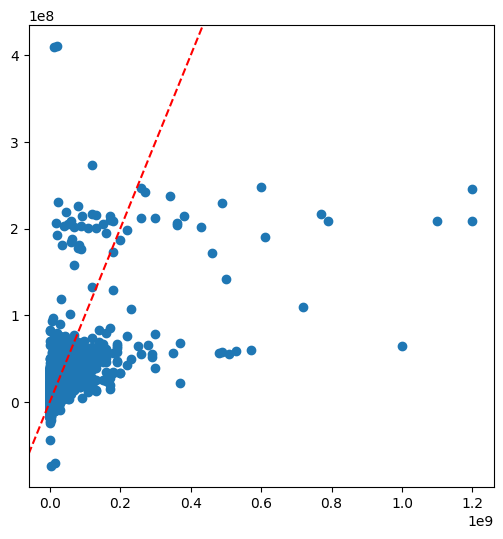

PoissonRegressor(max_iter=3000)
score:  0.6542250090800148


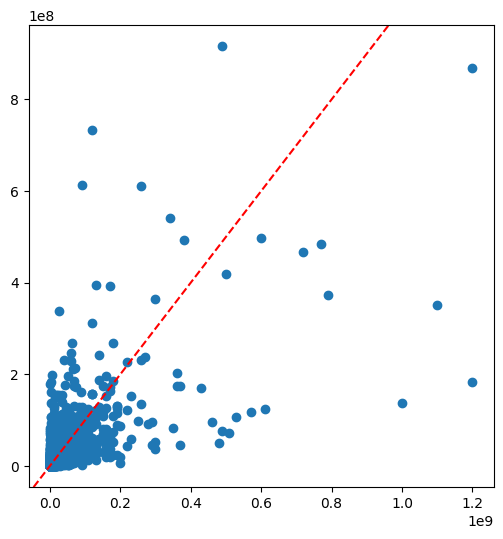

GammaRegressor()
score:  0.5204126363145763


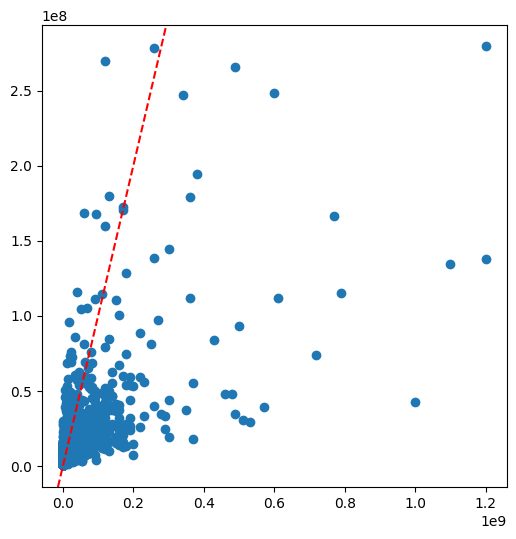

TweedieRegressor(max_iter=3000, power=1)
score:  0.6542250090800148


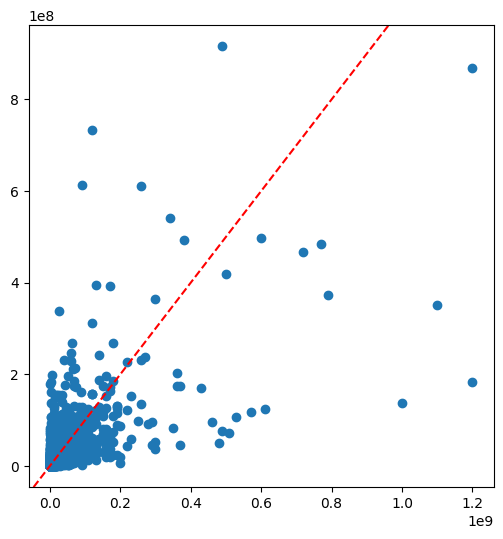

TweedieRegressor(max_iter=1500, power=2)
score:  0.5204126363145763


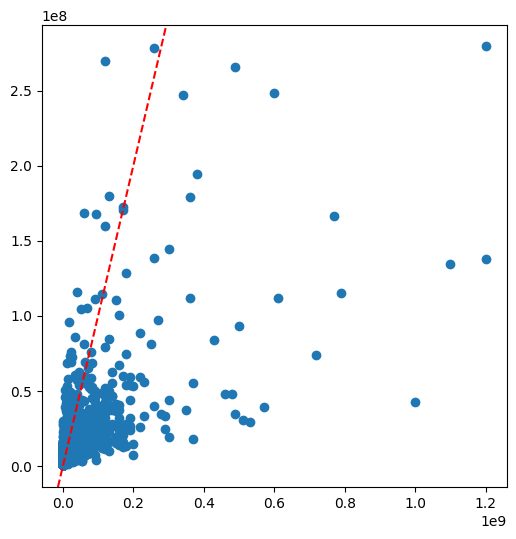

i:\miniconda\envs\inz--ai\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


KerasRegressor(
	model=<function build_dnn at 0x000001B46E847100>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=False
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
)
score:  0.37940417486088884


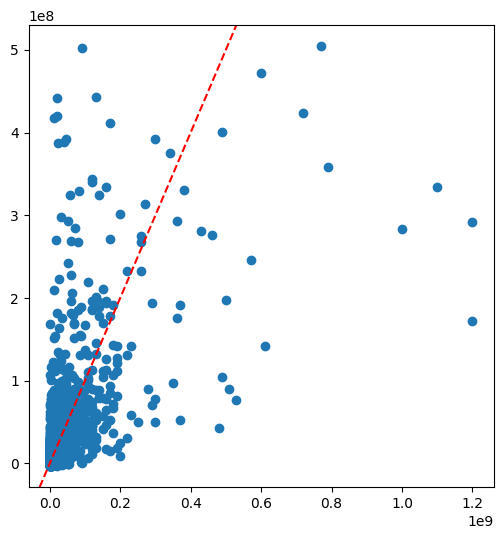

i:\miniconda\envs\inz--ai\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


VotingRegressor(estimators=[('gb_reg', GradientBoostingRegressor()),
                            ('dnn_reg',
                             KerasRegressor(epochs=50, model=<function build_dnn at 0x000001B46E847100>, verbose=False)),
                            ('gamma_reg', GammaRegressor()),
                            ('poisson_reg', PoissonRegressor(max_iter=3000)),
                            ('tweedie1_reg',
                             TweedieRegressor(max_iter=3000, power=1)),
                            ('tweedie2_reg',
                             TweedieRegressor(max_iter=1500, power=2))])
score:  0.4571522137907086


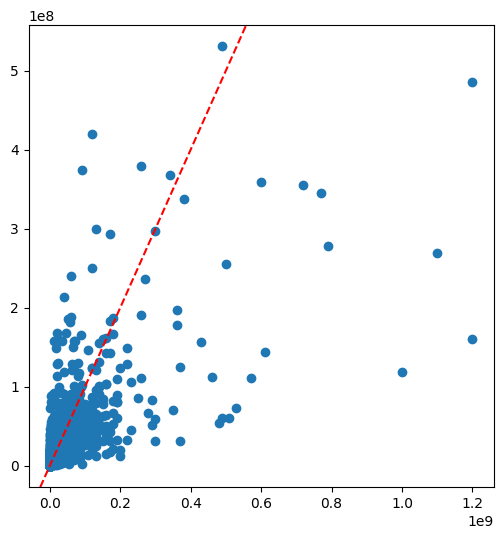

StackingRegressor(cv=5,
                  estimators=[('gb_reg', GradientBoostingRegressor()),
                              ('dnn_reg',
                               KerasRegressor(epochs=50, model=<function build_dnn at 0x000001B46E847100>, verbose=False)),
                              ('gamma_reg', GammaRegressor()),
                              ('poisson_reg', PoissonRegressor(max_iter=3000)),
                              ('tweedie1_reg',
                               TweedieRegressor(max_iter=3000, power=1)),
                              ('tweedie2_reg',
                               TweedieRegressor(max_iter=1500, power=2))],
                  final_estimator=ExtraTreesRegressor(), n_jobs=-1)
score:  0.320885069598842


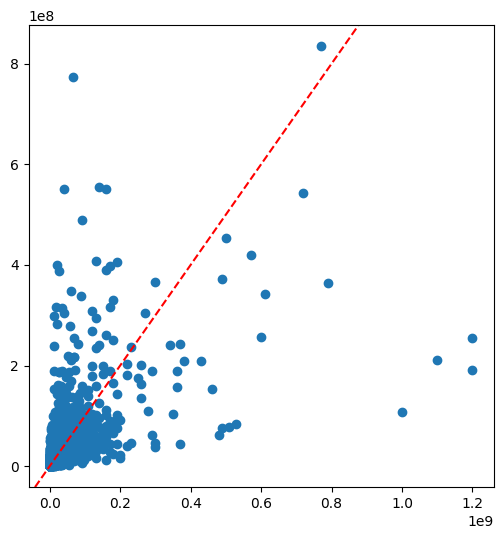

StackingRegressor(cv=5,
                  estimators=[('gb_reg', GradientBoostingRegressor()),
                              ('dnn_reg',
                               KerasRegressor(epochs=50, model=<function build_dnn at 0x000001B46E847100>, verbose=False)),
                              ('gamma_reg', GammaRegressor()),
                              ('poisson_reg', PoissonRegressor(max_iter=3000)),
                              ('tweedie1_reg',
                               TweedieRegressor(max_iter=3000, power=1)),
                              ('tweedie2_reg',
                               TweedieRegressor(max_iter=1500, power=2))],
                  final_estimator=RidgeCV(), n_jobs=-1)
score:  -65739900078.364334


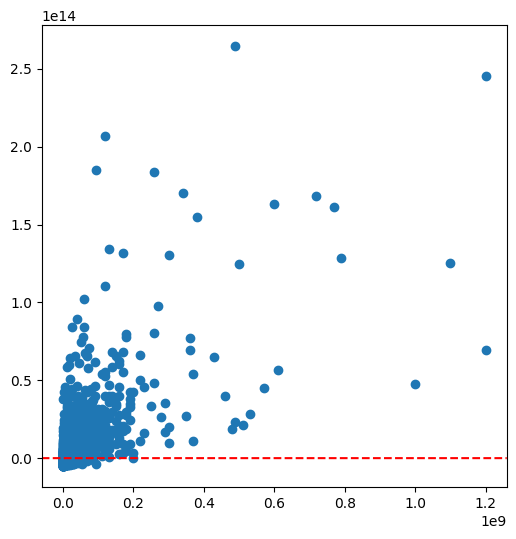

In [18]:
for model in create_models():
    #scores = cross_val_predict(model, df_japan, price, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1)
    #print(np.sqrt(np.mean((scores - price)**2)))
    hist = model.fit(X_train, y_train)
    # preds_valid=model.predict(X_test)
    # score_valid=mean_absolute_error(y_test,preds_valid)
    # print("MAE: ",score_valid)
    print(model[2])
    print("score: ", hist.score(X_test, y_test))
    
    predicted = model.predict(X_test)
    actual = y_test

    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(actual, predicted)
    axline((0, 0), (1, 1), color='r', linestyle='--')
    plt.show()

In [13]:

# new_list_of_models = [
#     Pipeline([
#         ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
#         ('scaler', StandardScaler()),
#         ('model', RANSACRegressor())
#     ]),
#     Pipeline([
#         ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
#         ('scaler', StandardScaler()),
#         ('model', ElasticNetCV())
#     ]),
#     Pipeline([
#         ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
#         ('scaler', StandardScaler()),
#         ('model', TheilSenRegressor())
#     ]),
#     Pipeline([
#         ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
#         ('scaler', StandardScaler()),
#         ('model', PassiveAggressiveRegressor())
#     ]),
# ]

# for model in create_models():
#     hist = model.fit(X_train, y_train)
#     print("score: ", hist.score(X_test, y_test))
#     predicted = model.predict(X_test)
#     actual = y_test

#     plt.scatter(actual, predicted)
#     plt.show()

In [14]:
import sklearn
print(f"scikit-learn: {sklearn.__version__}")

scikit-learn: 1.5.2
